# Stochastic Sensor Models & Gaussian White Noise

## Basic Continuous-Time and Discrete-Time Sensor Models

A sensor measuring a quantity $\mu(t)$ of interest could typically have a continuous-time measurement model of the form
$$
\tilde \mu(t) = (1-s(t)) \mu(t) + b(t) + \nu_\mu(t)
$$
where $\mu(t)$ is the true (unknown) value of the quantity of interest, $s$ is the scale factor error, $b$ is the bias, and $\nu_\mu(t)$ is a zero-mean stochastic noise process, which we discuss below. We often use continuous-time model for convenience to model even digital sensors with a fast sampling rate, such as inertial sensors (accelerometers and gyroscopes). The possibly time-varying parameters $s$ and $b$ are systematic error that we might be able to estimate and correct for (and should, in most cases, at least for $b$). On the other hand, $\nu_\mu(t)$ captures the remaining uncertainty in the model, which can never perfectly explain measurement variations. 

We might have additional information about the sensor, typically from a preliminary test phase, which we would like to include in the model. For example, here is a dynamic model of how the bias could evolve with time
$$
\dot b(t) = - \lambda b(t) + \nu_b(t),
\tag{1}
$$
where $\lambda > 0$ is a known constant, and $\nu_b$ is another zero-mean stochastic noise process. A simpler model is to assume $b$ constant (but still unknown), in which case we could perhaps estimate it offline once an for all. More realistically, $b$ could still be slowly varying over time, e.g., due to the sensor aging, or could take a different constant value every time the sensor is switched on. In these cases, we then still need to estimate $b$ as the sensor is operating or during a start-up phase.

For slower sensors, such as a GPS receiver, we might have a discrete-time model of the form
$$
y_k = (1-s_k) y_k + b_k + \eta_k,
$$
where again $s_k$ is a scale factor error, $b_k$ is a bias, and $\eta_k$ is a zero-mean random sequence. For $s_k$ and $b_k$, we might again have a dynamic model, either in continuous-time similar to $(1)$, in which case $b_k = b(t_k)$ for $t_0, t_1, \ldots$ a sequence of sampling times, or in discrete-time, e.g.,
$$
b_{k+1} = \alpha b_k + w_k,
\tag{2}
$$
for some $|\alpha| < 1$.

## Gaussian Processes and Sequences

Models such as $(1)$ or $(2)$ describe stochastic processes or sequences, driven here by noise terms $\nu_b(t)$ and $w_k$ in continuous-time and discrete-time respectively. So we need to define these objects a bit more precisely, especially since we will want to simulate and characterize them in order to adjust our system parameters and test our designs. Generally, $w_k$ and $\nu(t)$ will be white Gaussian noise terms in discrete-time and continuous-time respectively. We start with the discrete-time, which is conceptually much easier.

### Discrete-Time White Gaussian Noise

A sequence $w_0, w_1, \ldots$ will be called (discrete-time) white Gaussian noise (WGN) is for all $k$, $w_k$ is a Gaussian random vector (r.v.) of zero mean, and the autocorrelation sequence satisfies $R[k-l] = \mathbb E[w_k w_l^T] = W \delta_{k-l}$, i.e., $\mathbb E[w_k w_k^T] = W$ and $\mathbb E[w_k w_l^T] = 0$ for $k \neq l$. In other words, $w_k$ is a sequence of independent, identically distributed (iid) Gaussian r.v. Recall that a (jointly) Gaussian r.v. with mean $m$ and covariance matrix $\Sigma = \mathbb E[(w-m)(w-m)^T]$, denoted $w \sim \mathcal N(m,\Sigma)$, has a probability distribution with density (pdf)
$$
p(w) = \frac{1}{\sqrt{\det(2 \pi \Sigma)}} e^{-\frac{1}{2} (w - m)^T \Sigma^{-1} (x-m)}.
\tag{3}
$$
How would you generate a 2D Gaussian r.v. with say mean $\begin{bmatrix}1 \\ 2 \end{bmatrix}$ and covariance matrix $\Sigma = \begin{bmatrix}2 & 1 \\ 1 & 3 \end{bmatrix}$? Assuming your language's standard library already provides you a source of random iid scalar Gaussian variables, you can use the fact that expectation is additive and that if $w$ is a Gaussian r.v., so is $Aw$ for $A$ a matrix, and in fact
$$
w \sim \mathcal N(m,\Sigma) \Rightarrow Av \sim \mathcal N(Am, A \Sigma A^T).
$$
Now consider the following code

In [4]:
# julia code
w1 = randn(2)  # 0-mean 2D Gaussian r.v. with identity covariance matrix
m = [1;2]
Sigma = [2 1;1 3] 
A = sqrtm(Sigma)  # principal matrix square root, so that AA = Sigma (and A = A')
w = m + A * w1  # the Gaussian r.v. we wanted

2-element Array{Float64,1}:
 1.50185 
 0.184207

Let us now generate more of such vectors, in a way that the samples are iid, and plot these samples in the plane. We also define the confidence ellipsoids
$$
\mathcal E_{\alpha} = \{w | (w-m)^T \Sigma^{-1} (w-m) \leq \alpha\}.
$$
From the expression of the pdf $(3)$, we can compute that in $\mathbb R^2$ any sample has a probability or roughly $50\%$ of falling inside the ellipsoid $\mathcal E_n$, and a probability of roughly $90\%$ of falling inside $\mathcal E_{n+2\sqrt{n}}$.

In [5]:
nsamples = 1000
ws = zeros(2,nsamples)
for k=1:nsamples
    ws[:,k] = m + A * randn(2)
end

In [6]:
using Gadfly
#set_default_plot_size(20cm, 10cm)

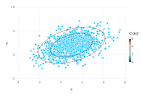

In [7]:
Sigmainv = inv(Sigma)
ellip(x,y) = Sigmainv[1,1] * (x-m[1])^2 + Sigmainv[2,2] * (y-m[2])^2 +
             2 * Sigmainv[1,2] * (x-m[1]) * (y-m[2])
# samples with roughly the 50% and 90% confidence ellipsoid
plot(layer(z=ellip, x=linspace(-7,7,150), y=linspace(-10,10,150), 
     Geom.contour(levels=[2,4.83])),layer(x=ws[1,:],y=ws[2,:],Geom.point))  

### Continuous-Time White Gaussian Noise and Brownian Motion

Continuous-time WGN $w(t)$ could be defined somewhat informally as a wide-sense stationary (WSS) Gaussian process with mean function zero
$$
m(t) = \mathbb E[w(t)] = 0
$$
and autocorrelation function
$$
R_w(t,s) = R_w(t-s) = W \delta(t-s),
$$
where now $\delta$ is the Dirac delta. $W$ is a power spectral density (PSD) matrix. The units of the entries of the matrix $W$ (which is often just a scalar), as you will find out in sensor datasheets, are expressed in 
$$
(\text{units of } w)^2 / Hz \text{ or equivalently } (\text{units of } w)^2 \cdot s.
$$
You might recall that the PSD of a WSS process is the Fourier transform of the autocorrelation function
$$
S_w(j\omega) = \int_{-\infty}^\infty R_w(\tau) e^{-j \omega \tau} d \tau,
$$
and $S_w(j\omega)$ represents the energy contained in the signal at frequency $\omega$. For our WGN, we get
$$
S_w(j\omega) = \int_{-\infty}^\infty W \delta(\tau) e^{-j \omega \tau} d \tau = W.
\tag{4}
$$
In other words, the PSD is constant and equal to $W$. The fact that $S_w(j\omega) = W$ also explains the origin of the units of $W$.

Continuous-time WGN is often convenient in engineering analysis, but can also be dangerous because sometimes it does not follow standard calculus rules. Note also that this is a process that has essentially infinite energy, because of its flat and constant PSD at all frequencies. Mathematically, it is hard to define it properly, and we prefer to work with its integral, another stochastic process. If $w$ is a scalar WGN with PSD 1, this integral is called called standard Brownian motion
$$
B(t) = \int_0^t w(\tau) d \tau,
$$
an equation that we can write formally as a differential equation 
$$
\dot B(t) = \frac{d B}{dt} (t) = w(t).
$$

So (1) could in fact be rewritten as
$$
\frac{db}{dt}(t) = -\lambda b(t) + \sigma \frac{dB}{dt}(t), 
$$
where $\sigma^2$ is the PSD of $\nu_b$, or more formally as
$$
db(t) = - \lambda b(t) dt + \sigma dB(t),
$$
which is just a convenient notation to mean
$$
b(t) = b(0) - \int_0^t \lambda b(s) ds + \sigma \int_0^t dB(s)
$$
i.e., 
$$
b(t) = b(0) - \int_0^t \lambda b(s) ds + \sigma B(s),
\tag{5}
$$
since $B(0) = 0$ by definition. 

The bottom line for this course is that you need to be able to simulate an equation such as (1), which turns out to correspond more rigorously to $(5)$. Suppose first that $\lambda = 0$. Then $b(t)$ is just Brownian motion, scaled by $\sigma$ and starting at a perhaps non zero value $b(0)$. You only need to known the following properties of standard Brownian motion $B(t)$
* B(0) = 0
* B has stationary increments, that is, for $0 \leq s < t$ the distribution of $B(t)-B(s)$ is the same as that of $B(t-s)-B(0) = B(t-s)$.
* B has independent increments that are normally distributed. That is, for $t_1, t_2, \ldots, t_n \in [0,\infty)$, with $t_1<t_2<\cdots<t_n$, the random variables $B({t_1})$, $B({t_2})−B({t_1}), \ldots, B({t_n})−B({t_{n−1}})$ are independent, and $B(t)-B(s) \sim \mathcal N(0,(t-s))$.

We can now simulate $b(t)$ in the case $\lambda = 0$, plotting the values $b(0), b(t_1), b(t_2), \ldots$ at sampling times $0, t_1, t_2, \ldots$. Start from $b(0)$. Then $b(t_1)-b(0) = \sigma B(t_1)$ is normally distributed with mean $0$ and variance $\sigma^2 t_1$. This allows you to plot $b(t_1)$. Then you redo the same: $b(t_2) - b(t_1)$ is normally distributed with mean $0$ and variance $\sigma^2 (t_2-t_1)$ (why). All the samples can be obtained by simply generating Gaussian random variables with the right variance. Here are some sample paths of $b(t)$, again for the case $\lambda = 0$.

In [8]:
sigma = 2
b0 = 1
npaths = 10  # number of sample paths
nsamples = 1000
dt = 0.01 # sampling period
b=b0*ones(npaths,nsamples)
for p=1:npaths
    for k=2:nsamples
        # stare at the following formula until you see why it's correct
        # omitting the time scaling here would not make sense
        b[p,k] = b[p,k-1] + sigma * sqrt(dt) * randn()  
    end
end

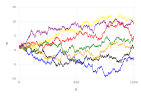

In [9]:
plot(layer(x=0:nsamples-1,y=b[1,:],Geom.line,Theme(default_color=colorant"orange")),
     layer(x=0:nsamples-1,y=b[2,:],Geom.line,Theme(default_color=colorant"purple")),
     layer(x=0:nsamples-1,y=b[3,:],Geom.line,Theme(default_color=colorant"red")),
     layer(x=0:nsamples-1,y=b[4,:],Geom.line,Theme(default_color=colorant"blue")),
     layer(x=0:nsamples-1,y=b[5,:],Geom.line,Theme(default_color=colorant"green")),
     layer(x=0:nsamples-1,y=b[6,:],Geom.line,Theme(default_color=colorant"yellow")),
     layer(x=0:nsamples-1,y=b[7,:],Geom.line,Theme(default_color=colorant"black"))
)

Now for the general case with $\lambda \neq 0$, we can formally integrate (1) as if $w$ were a deterministic function, to get, starting from sampling time $t_k$
$$
b(t) = e^{-\lambda (t-t_k)} b(t_k) + \sigma \int_0^{t-t_k} e^{-\lambda \tau} w(\tau) d\tau
= e^{-\lambda (t-t_k)} b(t_k) + \sigma \int_0^{t-t_k} e^{-\lambda \tau} dB(\tau).
$$
The strange object $\int_0^{t-t_k} e^{-\lambda \tau} dB(\tau)$ is an Itô stochastic integral, which we will not discuss formally here. Let us just introduce what we need for simulation. Suppose we have currently the sample $b(t_k)$, and we wish to generate the next sample $b(t_{k+1})$. Let $h_k := t_{k+1}-t_k$. Then
$$
b(t_{k+1}) = e^{-\lambda h_k} b(t_k) + \sigma \int_0^{h_k} e^{-\lambda \tau} dB(\tau).
$$
We see that to evaluate $b(t_{k+1})$, we only need to know something about the quantity $n_k := \int_0^{h_k} e^{-\lambda \tau} dB(\tau)$. It turns out that $n_k$ has a Gaussian distribution, with mean $0$, and so we only need to compute its variance. Reintroduce the formal notation $B(\tau) = w(\tau) d\tau$, it turns out that the following formal computation is valid
$$
\begin{align*}
var(n_k) &= \mathbb E \Big[ \int_0^{h_k} e^{-\lambda \tau} w(\tau) d\tau \int_0^{h_k} e^{-\lambda \tau'} w(\tau') d\tau' \Big] \\
&= \mathbb E \Big[ \int_0^{h_k} \int_0^{h_k} e^{-\lambda (\tau + \tau')} w(\tau) w(\tau') d\tau d\tau' \Big] \\
&= \mathbb E \Big[ \int_0^{h_k} \int_0^{h_k} e^{-\lambda (\tau + \tau')} \delta(\tau-\tau') d\tau d\tau' \Big] \\
&= \mathbb E \Big[ \int_0^{h_k} e^{-2 \lambda \tau} d\tau \Big]
= \frac{1-e^{-2 \lambda h_k}}{2\lambda} \approx h_k,
\end{align*}
$$
where the last approximation is valid only if the inter-sample time is "small enough".
Now consider the following code to simulate $(1)$.

In [10]:
sigma = 2
b0 = 10
lambda = 1.5
std_nk = sqrt((1-exp(-2*lambda*dt))/(2*lambda))
npaths = 10  # number of sample paths
nsamples = 1000
dt = 0.01 # sampling period
b=b0*ones(npaths,nsamples)
for p=1:npaths
    for k=2:nsamples
        # stare at the following formula until you see why it's correct  
        b[p,k] = exp(-lambda * dt) * b[p,k-1] + sigma * std_nk * randn()
    end
end

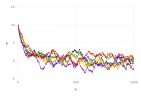

In [11]:
plot(layer(x=0:nsamples-1,y=b[1,:],Geom.line,Theme(default_color=colorant"orange")),
     layer(x=0:nsamples-1,y=b[2,:],Geom.line,Theme(default_color=colorant"purple")),
     layer(x=0:nsamples-1,y=b[3,:],Geom.line,Theme(default_color=colorant"red")),
     layer(x=0:nsamples-1,y=b[4,:],Geom.line,Theme(default_color=colorant"blue")),
     layer(x=0:nsamples-1,y=b[5,:],Geom.line,Theme(default_color=colorant"green")),
     layer(x=0:nsamples-1,y=b[6,:],Geom.line,Theme(default_color=colorant"yellow")),
     layer(x=0:nsamples-1,y=b[7,:],Geom.line,Theme(default_color=colorant"black"))
)

The vector-valued case is treated in Appendix B of the lecture notes. 

## Animation de marche aléatoire Gaussienne

In [14]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [19]:
dt = 0.005
b = 0.0
σ = 0.1

t = 0.0
plt = Plots.plot([t], [b], xlim = (0, 1))
ts = dt:dt:1
@gif for t ∈ ts
    b += σ * sqrt(dt) * randn()
    push!(plt, t, b)
    #push!(bs,b)
    #Plots.plot(0:dt:t+dt, bs, xlim = (0, 1))
end #every 5

LoadError: [91mcould not spawn `ffmpeg -v 0 -i /var/folders/g3/4cxx14gd05s2hvng2kh8f2nm0000gn/T/tmpdbg87F/%06d.png -vf palettegen=stats_mode=diff -y /var/folders/g3/4cxx14gd05s2hvng2kh8f2nm0000gn/T/tmpdbg87F/palette.bmp`: not a directory (ENOTDIR)[39m